In [2]:
import random
from numpy.random import sample as rs
from numpy import hstack as hs
from numpy import newaxis as na
from radd import theta
from scipy.stats import ttest_rel as ttrel
from scipy.stats.distributions import norm, uniform
from scipy.misc import factorial
prior = uniform.rvs(0,1,1000)

In [12]:
data=pd.read_csv("./CoAx/SSBayes/alldata_clean.csv")

In [3]:
dt=.0005
si=.01
tb=.56
ntot=1000
dx=np.sqrt(si*dt)

In [4]:
temporal_dynamics = lambda p, t: np.cosh(p['xb'][:,na]*t)
resp_up = lambda trace, a: np.argmax((trace.T>=a).T, axis=2)*dt
ss_resp_up = lambda trace, a: np.argmax((trace.T>=a).T, axis=3)*dt
resp_lo = lambda trace: np.argmax((trace.T<=0).T, axis=3)*dt
RT = lambda ontime, rbool: ontime[:,na]+(rbool*np.where(rbool==0, np.nan, 1))
RTQ = lambda zpd: map((lambda x:mq(x[0][x[0]<x[1]], prob)), zpd)
prop = lambda n, k: factorial(n)/(factorial(k)*factorial(n-k))
likelihood = lambda fact, prior, n, k: (fact*prior**k)*(1-prior)**(n-k)

In [5]:
p = theta.get_default_inits(kind='pro', depends_on={'v':'pGo'})
#p['vi']=1.2
#p['vd']=2.05

In [6]:
def vectorize_params(p, pc_map, ncond=1):
      pvc = ['a', 'tr', 'xb']
      for pkey in pvc:
            p[pkey]=p[pkey]*np.ones(ncond)
      for pkey, pkc in pc_map.items():
            if ncond==1:
                  p[pkey]=np.asarray([p[pkey]])
                  break
            elif pkc[0] not in p.keys():
                  p[pkey] = p[pkey]*np.ones(len(pkc))
            else:
                  p[pkey] = array([p[pc] for pc in pkc])
      return p



def update_execution(p):
      """ update Pg (probability of DVg +dx) and Tg (num go process timepoints)
      for go process and get get dynamic bias signal if 'x' model
      """
      #Pex = 0.5*(1 + (p['vd']/p['vi'])*dx/si)
      Pd = 0.5*(1 + p['vd']*dx/si)
      Pi = 0.5*(1 + p['vi']*dx/si)
      Tex = np.ceil((tb-p['tr'])/dt).astype(int)
      
      return Pd, Pi, Tex

In [7]:
nc=2
lr=.02
nssd=5
dt=.001
si=.1
ntot=200
tb=1.5

state = np.where(rs(ntot)>.5, 'l', 'r')
dx=np.sqrt(si*dt)

In [ ]:
stim_ids='abcdef'
ru = {ss: deepcopy(prior) for ss in s}
      

In [50]:
stim = [['a','b'], ['c', 'd'], ['e','f']]
pc_map = {'vd':['v_0', 'v_1'], 'vi': ['v_0', 'v_1']}
ntrials=50
p['vd']=[.9, .9]; p['vi']=[.4, .4]
p['a'] = .4
try:
      p.pop('v')
except Exception:
      pass

plist = [deepcopy(p) for i in xrange(len(stim))]
plist = [vectorize_params(p, pc_map, 2) for p in plist]

rand_stim = sum([sorted([0,1,2], key=lambda k: random.random()) for i in xrange(ntrials)], [])

preward = [.8,.7,.6]
nsuccess = 0
alpha_pos = .1
alpha_neg = .1
alpha=.05
traces = []


x = np.sort(uniform.rvs(0,1,1000))
prior = uniform.pdf(x)

stim_ids='abcdef'
ru = {sid: deepcopy(prior) for sid in stim_ids}     
stim_history = {sid: [0, 0] for sid in stim_ids}     
qdict = {sid: [.01] for sid in stim_ids}
di_qvals= {sid: {'vd':[.9], 'vi':[.4]} for sid in stim_ids}
qdict = {'a':[0.01], 'b':[0.01], 'c':[0.01], 'd':[0.01], 'e':[0.01], 'f':[0.01]}
#di_qvals = {'a':{'vd':[.9], 'vi':[.4]}, 'b':{'vd':[.9], 'vi':[.4]}, 'c':{'vd':[.9], 'vi':[.4]}, 'd':{'vd':[.9], 'vi':[.4]}, 'e':{'vd':[.9], 'vi':[.4]}, 'f':{'vd':[.9], 'vi':[.4]}}
#ru={'a':x, 'b':[0.01], 'c':[0.01], 'd':[0.01], 'e':[0.01], 'f':[0.01]}


In [51]:
for trial_n, i in enumerate(rand_stim):
      
      #if trial_n==int(.5*ntrials):
      #      preward=[.2,.3,.4]
      
      stim_pair_t = stim[i]
      stim_pair_qval = np.asarray([qdict[spt][-1] for spt in stim_pair_t])
      
      di_theta = plist[i]
      choice, execution_process = di_decision(di_theta)
      xchoice = abs(1-choice)
      traces.append(execution_process)
      
      if choice==0:
            r = rew_func(preward[i])
      else:
            r = rew_func(1-preward[i])
      
      # ID of chosen stimulus
      choice_id = stim_pair_t[choice]
      xchoice_id = stim_pair_t[xchoice]
      # update count (no. of times action has been chosen)
      stim_history[choice_id][0]+=1        
      
      # update chosen action value
      update_q = stim_pair_qval[choice] + alpha*(r-stim_pair_qval[choice])
      qdict[choice_id].append(update_q)
      qdict[xchoice_id].append(stim_pair_qval[xchoice])
      
      if r:
            # update nsuccess for chosen action
            stim_history[choice_id][1]+=1
            di_theta['vd'][choice] = di_theta['vd'][choice]+di_theta['vd'][choice]*update_q
            di_theta['vi'][choice] = di_theta['vi'][choice]-di_theta['vi'][choice]*(update_q*.5)
            if di_theta['vd'][choice]<0:
                  di_theta['vd'][choice]=.01
            if di_theta['vd'][choice]>=5.0:
                  di_theta['vd'][choice]=5.0
                  
      else:
            di_theta['vd'][choice] = di_theta['vd'][choice]-di_theta['vd'][choice]*(update_q*.5)
            di_theta['vi'][choice] = di_theta['vi'][choice]+di_theta['vi'][choice]*update_q
            
            if di_theta['vi'][choice]<0:
                  di_theta['vi'][choice]=.01
            if di_theta['vi'][choice]>=5.0:
                  di_theta['vi'][choice]=5.0
                  
      di_qvals[stim_pair_t[choice]]['vd'].append(di_theta['vd'][choice])
      di_qvals[stim_pair_t[choice]]['vi'].append(di_theta['vi'][choice])
      
      # extract action total count (n), nsuccess (s)
      n, s = stim_history[choice_id]
      # estimate posterior uncertainty in action value (from prior)
      ru[choice_id] = likelihood(prop(n+1, s), x, n, s)*ru[choice_id]

In [52]:
plt.plot(qdict['a'], label='a')
plt.plot(qdict['b'], label='b')

plt.plot(qdict['c'], label='c')
plt.plot(qdict['d'], label='d')

plt.plot(qdict['e'], label='e')
plt.plot(qdict['f'], label='f')
plt.legend()

In [49]:
plt.plot(x, ru['e'])

In [35]:
plt.plot(x, likelihood(prop(50, 45.), x, 50, 45)*prior)
plt.plot(x, likelihood(prop(100, 90.), x, 100, 90)*prior)

In [37]:
f, (ax1, ax2)=plt.subplots(2,1)
ax1.set_color_cycle(sns.color_palette('Reds', 2))
for i in traces[1]:
      ax1.plot(i)
ax2.set_color_cycle(sns.color_palette('Blues', 2))
for i in traces[-2]:
      ax2.plot(i, )

In [11]:
def rew_func(rprob): 
      if rs()<rprob:
            return 1
      else:
            return 0


def di_decision(p):
      
      #p = vectorize_params(p, pc_map=pc_map, ncond=nc)
      
      Pd = 0.5*(1 + p['vd']*dx/si)
      Pi = 0.5*(1 + p['vi']*dx/si)
      
      Tex = np.ceil((tb-p['tr'])/dt).astype(int)
      #state = np.where(rs(ntot)>.5, 'l', 'r')
      #state=np.sort(state)

      Pd, Pi, Tex = update_execution(p)
      xtb = temporal_dynamics(p, np.cumsum([dt]*Tex.max()))
      
      direct = xtb*np.where((rs((nc, Tex.max())).T < Pd),dx,-dx).T
      indirect = np.where((rs((nc, Tex.max())).T < Pi),dx,-dx).T
      execution = np.cumsum(direct-indirect, axis=1)
      
      choice=np.nan
      while np.isnan(choice):
            choice, p = analyze_execution(execution, p)
      
      return int(choice), execution
      
      
def analyze_execution(execution, p):
      
      rt = p['tr'] + np.argmax((execution.T>=p['a']).T, axis=1)*dt
      rt[rt==p['tr'][0]]=0

      #rt[rt>0] = p['tr'][0]+rt[rt>0]
      #rt[rt==0] = 999
      #rt = p['tr']+(rx*np.where(rx==0, 999, 1))
      
      
      if np.all(rt==0):
            #p['a']=p['a']*.99
            return np.nan, p
      
      return rt.argmin(), p

In [116]:
plist

[{'a': array([ 0.25,  0.25]),
  'tr': array([ 0.29213,  0.29213]),
  'vd': array([ 0.91791,  0.9    ]),
  'vi': array([ 0.39602,  0.4    ]),
  'xb': array([ 1.51129,  1.51129])},
 {'a': array([ 0.25,  0.25]),
  'tr': array([ 0.29213,  0.29213]),
  'vd': array([ 0.9,  0.9]),
  'vi': array([ 0.4,  0.4]),
  'xb': array([ 1.51129,  1.51129])},
 {'a': array([ 0.25,  0.25]),
  'tr': array([ 0.29213,  0.29213]),
  'vd': array([ 0.9,  0.9]),
  'vi': array([ 0.4,  0.4]),
  'xb': array([ 1.51129,  1.51129])}]

In [4]:
%matplotlib inline


In [38]:

plt.plot(qdict['a'], label='a')
plt.plot(qdict['b'], label='b')

plt.plot(qdict['c'], label='c')
plt.plot(qdict['d'], label='d')

plt.plot(qdict['e'], label='e')
plt.plot(qdict['f'], label='f')
plt.legend()

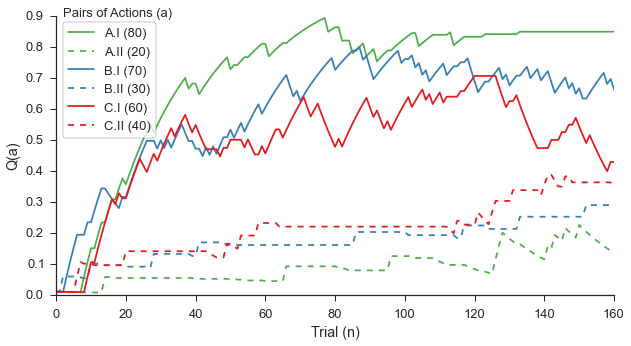

In [99]:
sns.set(font_scale=1.3, style='ticks')
f, ax = plt.subplots(1, figsize=(10,5))
plt.plot(qdict['a'], label='A.I (80)', color=flatui[2])
plt.plot(qdict['b'], label='A.II (20)', color=flatui[2], ls='--')

plt.plot(qdict['c'], label='B.I (70)', color=flatui[1])
plt.plot(qdict['d'], label='B.II (30)', color=flatui[1], ls='--')

plt.plot(qdict['e'], label='C.I (60)', color=flatui[0])
plt.plot(qdict['f'], label='C.II (40)', color=flatui[0], ls='--')
plt.legend(loc=2, fancybox=True, frameon=True, framealpha=.8)
plt.gca().text(2, .9, 'Pairs of Actions (a)', fontsize=13)
plt.gca().set_ylabel('Q(a)')
plt.gca().set_xlabel('Trial (n)')
sns.despine()
plt.savefig('probabilistic_qlearning_diexplorer.png', dpi=600)

In [261]:
qdict['f']

[0, 0.01, -9.9999999999999395e-05]

In [97]:
p = vectorize_params(p, pc_map=pc_map, ncond=nc)
Acc, RT, Resp, Vd, Vi, Ex = [], [], [], [], [], []
#state = np.where(rs(ntot)>.5, 'l', 'r')
#state=np.sort(state)
state=np.hstack([np.sort(['l', 'r']*20)]*3)
for i in xrange(len(state)):

      Pd, Pi, Tex = update_execution(p)
      direct = np.where((rs((nc, Tex.max())).T < Pd),dx,-dx).T
      indirect = np.where((rs((nc, Tex.max())).T < Pi),dx,-dx).T
      execution = np.cumsum(direct-indirect, axis=1)

      resp, rts, acc, p = analyze_execution(execution, p, trial_state=state[i])
      Acc.append(acc); Resp.append(resp); RT.append(rts)
      Vd.append(deepcopy(p['vd'])); Vi.append(deepcopy(p['vi']))                            
Acc=np.asarray(Acc)
RT=np.asarray(RT)
Resp=np.asarray(Resp)
Vd=np.asarray(Vd)    
Vi=np.asarray(Vi)    

In [66]:
def simulate_learning(p, pc_map={'vd':['vd_e', 'vd_u', 'vd_l'], 'vi':['vi_e', 'vi_u', 'vi_l']}, nc=3, lr=array([.4,.3]), nssd=5, dt=.0005, si=.01, ntot=1000, tb=.68):

      dx=np.sqrt(si*dt)
      p = vectorize_params(p, pc_map=pc_map, ncond=nc)

      #Pd, Pi, Tex = update_execution(p)
      #t = np.cumsum([dt]*Tex.max())
      #xtb = temporal_dynamics(p, t)

      #Ph, Th = update_brake(p)
      #ss_index = [np.where(Th<Tex[c],Tex[c]-Th,0) for c in range(nc)]
      #return Pd, Pi
      rts, vd, vi, ex = [], [], [], []
      for i in xrange(ntot):

            Pex, Tex = update_execution(p)
            execution = np.cumsum(np.where((rs((nc, Tex.max())).T < Pex),dx,-dx).T)
            #indirect = np.where((rs((nc, Tex.max())).T < Pi),dx,-dx).T
            #execution = np.cumsum(direct+indirect, axis=1)

            r = np.argmax((execution.T>=p['a']).T, axis=1)*dt
            rt = p['tr']+(r*np.where(r==0, np.nan, 1))
            resp = np.where(rt<tb, 1, 0)
            
            # find conditions where response was recorded
            #for ci in np.where(~np.isnan(rt))[0]:
            p['vd']=p['vd'] + p['vd']*lr[0]
            p['vi']=p['vi'] - p['vi']*lr[1]


            vd.append(deepcopy(p['vd']))
            vi.append(deepcopy(p['vi']))
            rts.append(rt)
            ex.append(execution)

      vd = np.asarray(vd)
      vi = np.asarray(vi)
      rts = np.asarray(rts)
      ex = np.asarray(ex)
      return vd, vi, rts, ex

In [95]:
p['z']=.2*p['a']
p = vectorize_params(p, pc_map=pc_map, ncond=2)

In [96]:
def analyze_execution(execution, p, trial_state):
      
      rt = p['tr'] + np.argmax((execution.T>=p['a']).T, axis=1)*dt
      rt[rt==p['tr'][0]]=999
      #rt[rt>0] = p['tr'][0]+rt[rt>0]
      #rt[rt==0] = 999
      #rt = p['tr']+(rx*np.where(rx==0, 999, 1))
      
      
      if np.all(rt==999):
            p['vd'] = p['vd']*1.02
            return [0,0], rt, 0, p
      
      r = np.where(rt==rt.min(), 1, 0)
      
      if trial_state=='l':
            if r[0]:
                  acc=1
                  p['vd'][0]=p['vd'][0]*1.02
                  p['vi'][0]=p['vi'][0]*.98
            elif r[1]:
                  acc=0
                  p['vi'][1]=p['vi'][1]*1.02
                  p['vd'][1]=p['vd'][1]*.98
      else:
            if r[0]:
                  acc=0
                  p['vi'][0]=p['vi'][0]*1.02
                  p['vd'][0]=p['vd'][0]*.98
            elif r[1]:
                  acc=1
                  p['vd'][1]=p['vd'][1]*1.02
                  p['vi'][1]=p['vi'][1]*.98
            
      #p['vd']=p['vd']+p['vd']*(acc*lr)
      #p['vi']=p['vi']+p['vi']*(err*lr)        
      
      #if np.any(rt[~np.isnan(rt)]<.4):
      #      print 'INSIDE'
      #      dirac = np.where(rts<.4, 1, 0)
      #      p['vd']=p['vd']-p['vd']*(dirac*lr)
      #      p['vi']=p['vd']+p['vi']*(dirac*lr)
      
      return r, rt, acc, p

In [52]:
indirect = np.where((rs((10, Tex.max())).T < Pi),dx,-dx).T

array([ 0.,  1.,  2.,  3.])

In [92]:
mu = array([.15,.3,.08])
eta = .05
norm.rvs(mu[1], .2, 100)

array([ 0.06438,  0.04846,  0.17579,  0.12416,  0.16253, -0.15569,
        0.45984,  0.28123,  0.16796, -0.07647, -0.00409,  0.43277,
       -0.011  ,  0.33468,  0.55174,  0.30955,  0.64753,  0.35834,
        0.51083,  0.24231,  0.4098 ,  0.26724,  0.45731,  0.01023,
        0.57246,  0.38678,  0.07561,  0.46164,  0.47789,  0.3585 ,
        0.25998,  0.45393,  0.66845,  0.29605,  0.28592,  0.6772 ,
        0.19671,  0.51665,  0.46125, -0.04849,  0.60721,  0.34887,
        0.11345,  0.23038,  0.10535,  0.32742,  0.25306,  0.32326,
       -0.07715,  0.39264,  0.11808,  0.46458,  0.00518,  0.18102,
        0.28876,  0.33205,  0.21044,  0.35243,  0.11448,  0.20089,
        0.01665,  0.17665,  0.28239, -0.11559,  0.38506,  0.54016,
        0.48068,  0.37529,  0.06952,  0.49478,  0.27   ,  0.05358,
        0.10083,  0.20155,  0.20363,  0.34496,  0.17737,  0.0203 ,
        0.326  ,  0.15416,  0.32243,  0.3899 ,  0.55521,  0.2844 ,
        0.40197,  0.37023, -0.07818,  0.36791,  0.2818 , -0.10

In [77]:
p['vd']

array([ 0.72029,  0.89774])

In [946]:
RT[RT==999]=np.nan

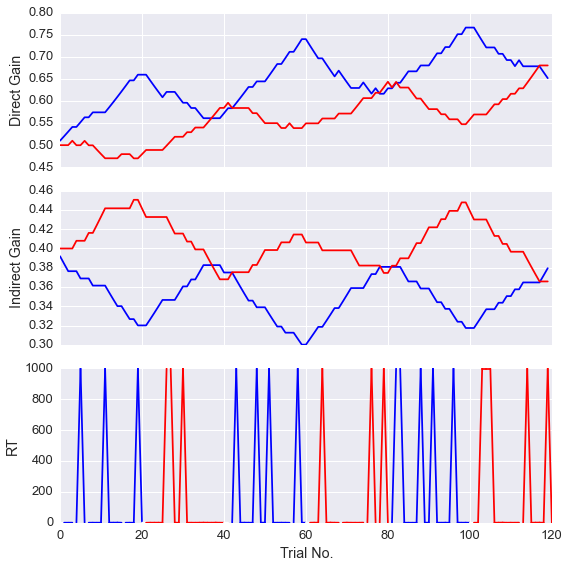

In [99]:
sns.set(font_scale=1.3)

f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8), sharex=True) 

ax1.plot(Vd[:,0], color='b')
ax1.plot(Vd[:,1], color='r')

ax2.plot(Vi[:,0], color='b')
ax2.plot(Vi[:,1], color='r')

#ax3.plot(RT[:,0], color='b')
#ax3.plot(RT[:,1], color='r')
#f, ax = plt.subplots(1) 

rt_tminus1=RT[4].min()
for i, trial_rt in enumerate(RT):
      
      if trial_rt.min()==999:
            continue
            
      c='r'; ix=1
      if state[i]=='l':
            c='b'; ix=0
      if state[i-1]!=state[i]:
            c='White'
      ax3.plot([i, i+1], [rt_tminus1, trial_rt[ix]], color=c)
      rt_tminus1=trial_rt[ix]

sns.despine()
ax1.set_ylabel('Direct Gain')
ax2.set_ylabel('Indirect Gain')
ax3.set_ylabel('RT')
ax3.set_xlabel('Trial No.')
#ax3.set_ylim(0, .4)
plt.tight_layout()

#f.savefig(pth+'learner.png', dpi=600)

In [975]:
f, ax = plt.subplots(1) 

rt_tminus1=RT[4].min()
for i, trial_rt in enumerate(RT):
      
      if trial_rt.min()==999:
            continue
            
      c='r'; ix=1
      if state[i]=='l':
            c='b'; ix=0
      if state[i-1]!=state[i]:
            c='White'
      ax.plot([i, i+1], [rt_tminus1, trial_rt[ix]], color=c)
      rt_tminus1=trial_rt[ix]

sns.despine()

In [716]:
pd.DataFrame({'state':state, 'acc'Acc[]

array(['r', 'l', 'l', 'r', 'r', 'r', 'r', 'r', 'l', 'r', 'r', 'l', 'r',
       'r', 'l', 'l', 'r', 'r', 'l', 'l', 'l', 'r', 'r', 'l', 'r', 'l',
       'l', 'r', 'l', 'l', 'r', 'l', 'l', 'r', 'l', 'r', 'l', 'r', 'l',
       'l', 'l', 'l', 'l', 'r', 'r', 'l', 'r', 'l', 'r', 'r'], 
      dtype='|S1')

In [648]:
if np.all(resp==0):
      p['vd']*1.02
elif np.any(rts<.3):
      p['vd'][rts.argmin()]*.98
      p['vi'][rts.argmin()]*1.02

In [726]:
a=[1,.5]
for i, x in enumerate(execution):
      plt.plot(x, color='g', alpha=a[i])

In [319]:
rt[0]=0.

In [324]:
rx = np.argmax((execution.T>=p['a']).T, axis=1)*dt

In [322]:
rt[rt!=0.]

array([ 1.])

In [321]:
rt

array([ 0.,  1.])

In [280]:
p = vectorize_params(p, pc_map=pc_map, ncond=nc)
#Ph, Th = update_brake(p)
#ss_index = [np.where(Th<Tex[c],Tex[c]-Th,0) for c in range(nc)]
#return Pd, Pi
acc, rts, rsp, vd, vi, ex = [], [], [], [], [], []
for i in xrange(ntot):

      Pd, Pi, Tex = update_execution(p)
      #execution = np.cumsum(np.where((rs((nc, Tex.max())).T < Pex),dx,-dx).T, axis=1)
      direct = np.where((rs((nc, Tex.max())).T < Pd),dx,-dx).T
      indirect = np.where((rs((nc, Tex.max())).T < Pi),dx,-dx).T
      execution = np.cumsum(direct-indirect, axis=1)

      rx = np.argmax((execution.T>=p['a']).T, axis=1)*dt
      rt = p['tr']+(rx*np.where(rx==0, 999, 1))
      r = np.where(rt==rt.min(), 1, 0)
      
      #if i<25:
      if np.any(rt)<.3:
            continue
      elif r[0] and state[i]=='l':
            acc.append(1)
            p['vd'][0]=p['vd'][0] + p['vd'][0]*lr
      elif r[0] and state[i]=='r':
            acc.append(0)
            p['vi'][0]=p['vi'][0] + p['vi'][0]*lr  

      # find conditions where response was recorded
      #for ci in np.where(~np.isnan(rt))[0]:
      #p['vd']=p['vd'] + p['vd']*lr[0]
      #p['vi']=p['vi'] - p['vi']*lr[1]



      vd.append(deepcopy(p['vd']))
      vi.append(deepcopy(p['vi']))
      rts.append(rt)
      rsp.append(r)
      ex.append(execution)

vd = np.asarray(vd)
vi = np.asarray(vi)
rts = np.asarray(rts)
ex = np.asarray(ex)
rsp = np.asarray(rsp)

In [285]:
p['vd'][0]*.2

59600410.853256039

In [279]:
p['a']=.5

p['vi_left']=.3
p['vd_left']=.5

p['vi_right']=.2
p['vd_right']=.4
#p['vd_right']

In [79]:
p = theta.get_default_inits(kind='pro', depends_on={'v':'pGo'})
p['vi_e']=-1.2
p['vd_e']=5.0

p['vi_u']=-1.2
p['vd_u']=2.0

p['vi_l']=-1.2
p['vd_l']=1.5

p['a']=.5

In [28]:
pd, pi = simulate_learning(p, nc=2, pc_map=pc_map, nssd=0, ntot=ntot, tb=.68, lr=lr, si=.01)

In [33]:
pc_map={'vd':['vd_left', 'vd_right'], 'vi':['vi_left', 'vi_right']} 
nc=2
lr=array([.3,.4])
nssd=5
dt=.0005
si=.1
ntot=50
tb=2
vd, vi, rts, ex = simulate_learning(p, nc=2, pc_map=pc_map, nssd=0, ntot=ntot, tb=tb, lr=lr, si=.01)

In [237]:
p

{'a': array([ 0.29,  0.29]),
 'tr': array([ 0.29213,  0.29213]),
 'v': array([ 1.718,  1.718]),
 'vd': array([ 13.43145,   0.08722]),
 'vd_e': 5.0,
 'vd_l': 1.5,
 'vd_left': 1.5,
 'vd_right': 1.5,
 'vd_u': 2.0,
 'vi': array([  0.10636,  15.73199]),
 'vi_e': -1.2,
 'vi_l': -1.2,
 'vi_left': 1.2,
 'vi_right': 1.2,
 'vi_u': -1.2,
 'xb': array([ 1.51129,  1.51129])}

In [456]:
a=[1,.5]
for i, x in enumerate(execution):
      plt.plot(x, color='g', alpha=a[i])
#for i, x in enumerate(execution):
#      plt.plot(x, color='r', alpha=a[i])      

In [224]:
state

array(['a', 'a', 'a', 'a', 's', 's', 's', 'a', 's', 's', 'a', 'a', 's',
       'a', 's', 's', 'a', 'a', 's', 's', 's', 's', 'a', 's', 's', 's',
       's', 'a', 'a', 'a', 'a', 'a', 's', 's', 'a', 'a', 's', 'a', 's',
       'a', 'a', 's', 'a', 'a', 's', 's', 'a', 'a', 'a', 's'], 
      dtype='|S1')

In [236]:
plt.plot(acc)

In [278]:
vd

array([[  5.00000e-01,   4.00000e-01],
       [  5.00000e-01,   4.00000e-01],
       [  5.00000e-01,   4.00000e-01],
       [  5.00000e-01,   4.00000e-01],
       [  5.00000e-01,   4.00000e-01],
       [  5.50000e-01,   4.00000e-01],
       [  6.05000e-01,   4.00000e-01],
       [  6.65500e-01,   4.00000e-01],
       [  6.65500e-01,   4.00000e-01],
       [  7.32050e-01,   4.00000e-01],
       [  7.32050e-01,   4.00000e-01],
       [  7.32050e-01,   4.00000e-01],
       [  7.32050e-01,   4.00000e-01],
       [  8.05255e-01,   4.00000e-01],
       [  8.05255e-01,   4.00000e-01],
       [  8.05255e-01,   4.00000e-01],
       [  8.05255e-01,   4.00000e-01],
       [  8.05255e-01,   4.00000e-01],
       [  8.05255e-01,   4.00000e-01],
       [  8.85781e-01,   4.00000e-01],
       [  8.85781e-01,   4.00000e-01],
       [  8.85781e-01,   4.00000e-01],
       [  8.85781e-01,   4.00000e-01],
       [  9.74359e-01,   4.00000e-01],
       [  9.74359e-01,   4.00000e-01],
       [  9.74359e-01,   

In [277]:
f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,10)) 

ax1.plot(vd[:,1])
ax1.plot(vi[:,1])

#ax2.plot(vd[:,1])
#ax2.plot(vi[:,1])

ax2.plot(rsp[:,1])
ax2.plot(rsp[:,0])


ax3.plot(rts[:,1])
ax3.plot(rts[:,0])

In [280]:
lr=array([.4,.3])
p = vectorize_params(p, pc_map={'vd':['vd_e', 'vd_u', 'vd_l'], 'vi':['vi_e', 'vi_u', 'vi_l']}, ncond=3)
nc = len(p['vd']); nssd=5; 

Pd, Pi, Tex = update_execution(p)
t = np.cumsum([dt]*Tex.max())
xtb = temporal_dynamics(p, t)

#Ph, Th = update_brake(p)
#ss_index = [np.where(Th<Tex[c],Tex[c]-Th,0) for c in range(nc)]
rts, vd, vi = [], [], []

for i in xrange(ntot):

      Pd, Pi, Tex = update_execution(p)

      direct = np.where((rs((nc, Tex.max())).T < Pd),dx,-dx).T
      indirect = np.where((rs((nc, Tex.max())).T < Pi),dx,-dx).T
      execution = np.cumsum(direct+indirect, axis=1)
      
      #if i<=int(.5*ntot):
      #      init_ss = array([[execution[c,ix] for ix in ss_index] for c in range(nc)])
      #      hyper = init_ss[:,:,:,None]+np.cumsum(np.where(rs(Th.max())<Ph, dx, -dx), axis=1)

      
      r = np.argmax((execution.T>=p['a']).T, axis=1)*dt
      rt = p['tr']+(r*np.where(r==0, np.nan, 1))

      resp = np.where(rt<tb, 1, 0)
      # find conditions where response was recorded
      for ci in np.where(~np.isnan(rt))[0]:
            p['vd'][ci]=p['vd'][ci] + p['vd'][ci]*(lr[0]*(rt[ci]-.500))
            p['vi'][ci]=p['vi'][ci] - p['vi'][ci]*(lr[1]*(rt[ci]-.500))
      
      vd.append(deepcopy(p['vd']))
      vi.append(deepcopy(p['vi']))
      rts.append(rt)

vd = np.asarray(vd)
vi = np.asarray(vi)
rts = np.asarray(rts)

In [314]:
from radd import build
prodata=pd.read_csv("/Users/kyle/Dropbox/CoAx/ELife/Data/pro_data_elife.csv")
m=build.Model(data=prodata, kind='xpro')

In [81]:
plt.plot(execution[2, :], color='g')
#plt.plot(-vi[:50, 1], color='b')
#plt.plot((rts[:50, 0]-.5)/np.nanstd(rts[:50,0]), color='k')#np.nanmean(rts[:50, 0]), color='k')

IndexError: index 2 is out of bounds for axis 0 with size 2

In [210]:
top = data[(data.idx==105) & (data.trial<340) & (data.response==1) & (data.acc==1)]
bottom = data[(data.idx==105) & (data.trial>=340) & (data.response==1) & (data.acc==1)]

In [274]:
toprt=top.rt.values
brt=bottom.rt.values
ttrel(toprt, brt)
#len(toprt)
#len(brt)
toprt.mean()

test=[]
for ix, ixdf in dat.query('cond=="uniform"').copy().groupby('idx'):
      nt = len(ixdf)
      
      split = int(np.floor(nt/2))
      top = ixdf[ixdf.trial<split]
      bottom = ixdf[ixdf.trial>=split]
      if nt%2:
            bottom = bottom[:-1]
      test.append(ttrel(top.rt, bottom.rt))


In [278]:
for c, cdf in dat.groupby('cond'):
      print c, len(cdf.idx.unique())

early 25
late 25
uniform 25


In [279]:
test=np.asarray(test).reshape(len(test),2)
print len(test)
test[:,1][test[:,1]<.05]


25


array([  7.69179e-20,   1.11085e-07,   4.41859e-04,   4.49420e-03,
         7.58953e-03,   7.07363e-28,   1.25581e-05,   4.29148e-02,
         3.57535e-04,   8.31906e-03,   5.12948e-04,   9.13811e-08,
         2.46623e-02,   1.75057e-02,   2.58707e-02,   4.36565e-06])

In [264]:
plt.plot(dat.query('cond=="early"').groupby('trial').mean().rt*1, alpha=.8, color='b')
plt.plot(dat.query('cond=="late"').groupby('trial').mean().rt*-1, alpha=.6, color='r')
#plt.plot(dat.query('cond=="uniform"').groupby('trial').mean().rt, alpha=.4)

In [252]:
test = np.asarray(test).reshape(len(test), 2)
plt.plot(test[:,0], color='b')
plt.plot(test[:,1], color='r')

In [188]:
ixdfs=[]
for ix, ixdf in data.copy().groupby('idx'):
      ixdf['trial']=np.arange(len(ixdf))
      ixdfs.append(ixdf)
dat = pd.concat(ixdfs)

/Users/kyle/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [209]:
dat[]
len(dat[dat.idx==105])

680

In [165]:
plt.plot(rts[:10, 0], color='g')
plt.plot(rts[-20:-1, 0], color='r')
#plt.plot(np.cumsum(indirect[1]), color='b')

In [ ]:
plt.plot(np.cumsum(D[0]), color='g')
plt.plot(np.cumsum(I[0]), color='g')

In [48]:
Resp

array([[0, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 1],
       [1, 0],
       [1, 0],
       [1, 1],
       [1, 1],
       [1, 0],
       [1, 1],
       [1, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [1, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 0],
       [1, 0],
       [1, 1],
       [1, 0],
       [1, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 1],
       [1, 0],
       [1, 1],
       [1, 0],
       [1, 1],
       [0, 1],
       [1, 1],
       [1, 0],
       [1, 1],
       [1, 1],
       [0, 1],
       [0,

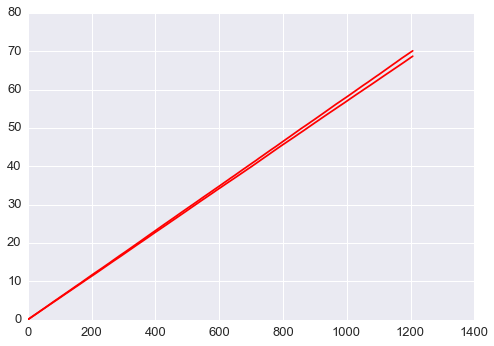

In [49]:
plt.plot(execution[1], color='r')
plt.plot(execution[0], color='r')

#plt.plot(E[0], color='r')

plt.legend()